In [4]:
import pandas as pd
import random
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import hnswlib
import pyterrier as pt
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec

In [5]:
ds = load_dataset("FreedomIntelligence/RAG-Instruct", split="train[:80%]")

README.md:   0%|          | 0.00/2.64k [00:00<?, ?B/s]

rag_instruct.json:   0%|          | 0.00/296M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40541 [00:00<?, ? examples/s]

## Basic stats of the dataset

In [6]:
print(f"Number of samples for training set: {ds.num_rows}")
print(f"Features of the dataset: {ds.column_names}")

Number of samples for training set: 32433
Features of the dataset: ['question', 'answer', 'documents']


In [7]:
q_word_counts = [len(s['question'].split()) for s in ds]
a_word_counts = [len(s['answer'].split()) for s in ds]
d_counts = [len(s) for s in ds['documents']]
words_d_counts = [len(d.split()) for s in ds for d in s['documents']]

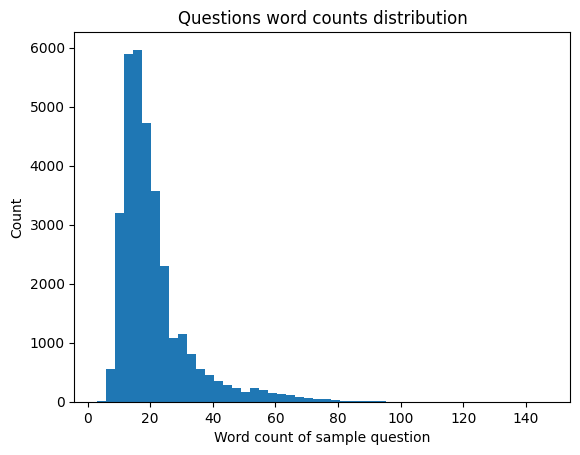

Avarage word count for questions: 20.992322634353897


In [8]:
plt.hist(q_word_counts, bins=50)
plt.xlabel('Word count of sample question')
plt.ylabel('Count')
plt.title('Questions word counts distribution')
plt.show()

print(f"Avarage word count for questions: {np.mean(q_word_counts)}")

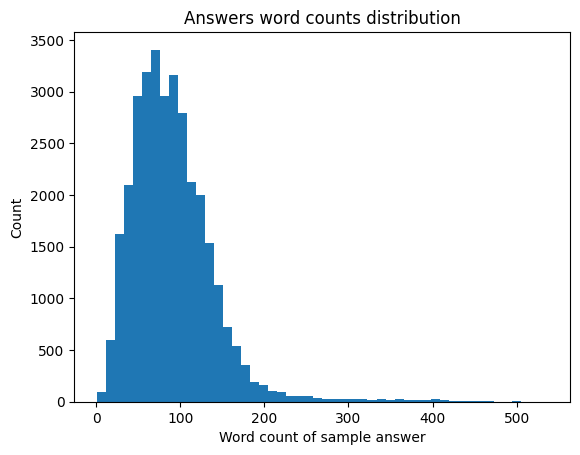

Avarage word count for answers: 91.04245675700675


In [9]:
plt.hist(a_word_counts, bins=50)
plt.xlabel('Word count of sample answer')
plt.ylabel('Count')
plt.title('Answers word counts distribution')
plt.show()

print(f"Avarage word count for answers: {np.mean(a_word_counts)}")

*Each QA has 10 documents, each having exactly 100 words:*

In [10]:
print(f"Document counts: {np.unique(d_counts)[0]}")
print(f"Word counts: {np.unique(words_d_counts)[0]}")

Document counts: 10
Word counts: 100


In [11]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def filter_words(s):
    s = s.lower()
    s = re.sub(r'\W+', ' ', s)
    words = s.split()
    words = [word for word in words 
             if word.isalpha() and word not in stop_words and len(word) > 1
    ]
    return words

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
q_vocabulary = nltk.FreqDist()
a_vocabulary = nltk.FreqDist()
docs_vocabulary = nltk.FreqDist()

for s in ds:
    words_q = filter_words(s['question'])
    words_a = filter_words(s['answer'])
    for d in s['documents']:
        words_doc = filter_words(d)
        docs_vocabulary.update(words_doc)
        
    q_vocabulary.update(words_q)
    a_vocabulary.update(words_a)

In [13]:
print(f"Questions vocabulary size: {len(q_vocabulary)}")
print(f"Answers vocabulary size: {len(a_vocabulary)}")
print(f"Documents vocabulary size: {len(docs_vocabulary)}")

Questions vocabulary size: 35411
Answers vocabulary size: 69259
Documents vocabulary size: 373006


In [14]:
vocab_size = len(set(q_vocabulary) | set(a_vocabulary) | set(docs_vocabulary))
print(f"Total vocabulary size: {vocab_size}")

Total vocabulary size: 373945


In [15]:
print("Most common words in questions:")
print(*q_vocabulary.most_common(10), sep='\n')

Most common words in questions:
('following', 3414)
('explain', 3188)
('question', 2473)
('answer', 2308)
('correct', 2004)
('describe', 1903)
('options', 1901)
('statement', 1892)
('discuss', 1769)
('true', 1688)


In [16]:
print("Most common words in answers:")
print(*a_vocabulary.most_common(10), sep='\n')

Most common words in answers:
('like', 11104)
('text', 5771)
('also', 5039)
('significant', 4946)
('used', 4675)
('data', 4475)
('due', 4298)
('additionally', 4126)
('one', 3927)
('use', 3918)


In [17]:
voc_size_q = [len(filter_words(s['question'])) for s in ds]
voc_size_a = [len(filter_words(s['answer'])) for s in ds]
voc_size_doc = [len(filter_words(d)) for s in ds for d in s['documents']]

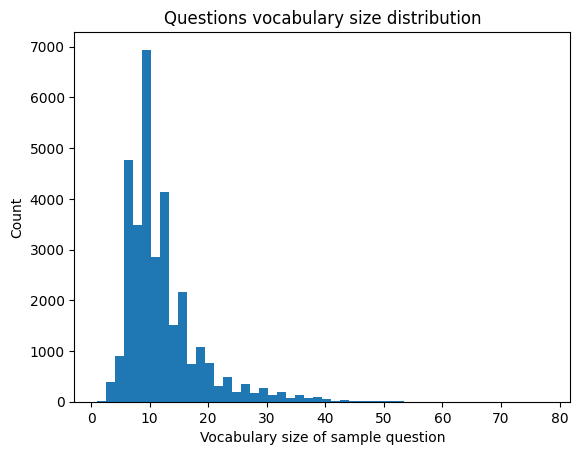

Avarage vocabulary size of questions: 55.80862084913514


In [18]:
plt.hist(voc_size_q, bins=50)
plt.xlabel('Vocabulary size of sample question')
plt.ylabel('Count')
plt.title('Questions vocabulary size distribution')
plt.show()

print(f"Avarage vocabulary size of questions: {np.mean(voc_size_a)}")

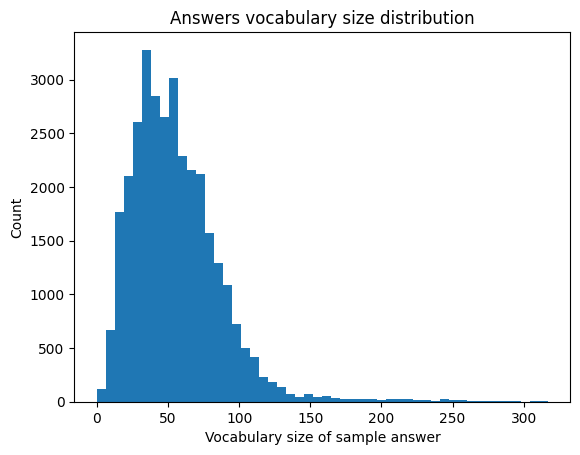

Avarage vocabulary size of answers: 55.80862084913514


In [19]:
plt.hist(voc_size_a, bins=50)
plt.xlabel('Vocabulary size of sample answer')
plt.ylabel('Count')
plt.title('Answers vocabulary size distribution')
plt.show()

print(f"Avarage vocabulary size of answers: {np.mean(voc_size_a)}")

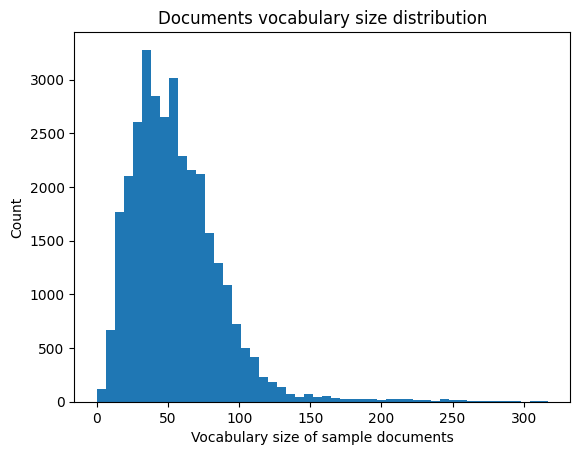

Avarage vocabulary size of documents: 57.76532852341751


In [20]:
plt.hist(voc_size_a, bins=50)
plt.xlabel('Vocabulary size of sample documents')
plt.ylabel('Count')
plt.title('Documents vocabulary size distribution')
plt.show()

print(f"Avarage vocabulary size of documents: {np.mean(voc_size_doc)}")

## Clusterings

In [21]:
questions = [q for q in ds['question']]

q_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

q_vectorizer.fit(questions)

vector_q = q_vectorizer.transform(questions)

In [22]:
"""
silhouette_scores = []
ks = [50, 60, 80, 100, 120, 130, 140, 145, 150, 200]

for k in ks:
    print(f"k={k}")
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(vector_q)
    score = silhouette_score(vector_q, labels)
    silhouette_scores.append(score)

plt.plot(ks, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score analysis')
plt.show()
"""

'\nsilhouette_scores = []\nks = [50, 60, 80, 100, 120, 130, 140, 145, 150, 200]\n\nfor k in ks:\n    print(f"k={k}")\n    kmeans = KMeans(n_clusters=k, random_state=42)\n    labels = kmeans.fit_predict(vector_q)\n    score = silhouette_score(vector_q, labels)\n    silhouette_scores.append(score)\n\nplt.plot(ks, silhouette_scores, \'bx-\')\nplt.xlabel(\'k\')\nplt.ylabel(\'Silhouette score\')\nplt.title(\'Silhouette score analysis\')\nplt.show()\n'

*k=150 seems to be a reasonable number of clusters to divide the questions (possible topics)*

In [23]:
kmeans = KMeans(n_clusters=150, random_state=42)
labels = kmeans.fit_predict(vector_q) 

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


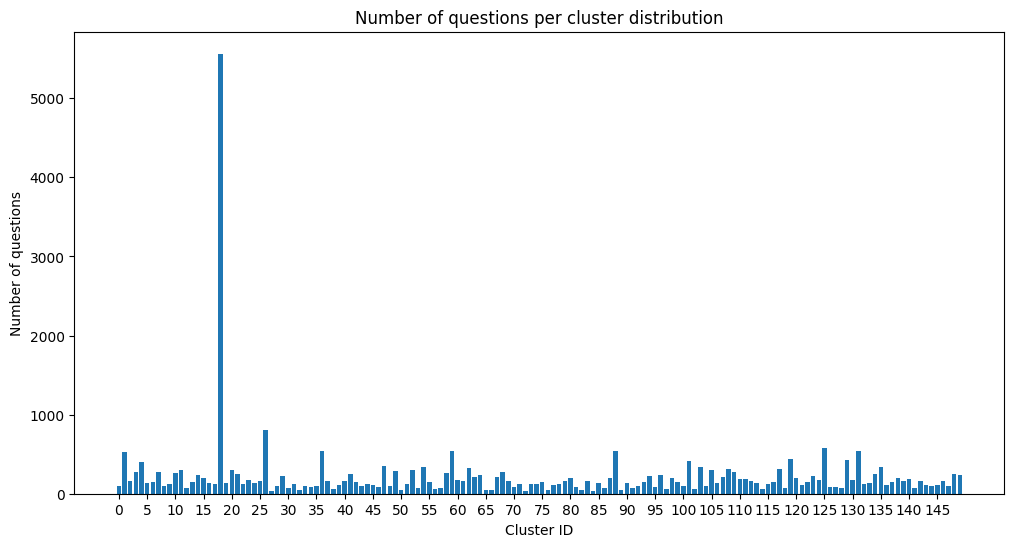

In [24]:
unique_labels, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(12,6))
plt.bar(unique_labels, counts, width=0.8)
plt.xlabel('Cluster ID')
plt.ylabel('Number of questions')
plt.title('Number of questions per cluster distribution')
plt.xticks(unique_labels[::5])#, rotation=90)
plt.show()

In [25]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(vector_q)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

[array([0.02402573, 0.03205775, 0.04124678, ..., 0.03104143, 0.01453819,
        0.01320188]),
 array([0.03490434, 0.06315981, 0.09025494, ..., 0.05706722, 0.01866319,
        0.01667087]),
 array([-0.0438259 , -0.04084217, -0.05113857, ..., -0.05243508,
        -0.03207298, -0.02183357])]

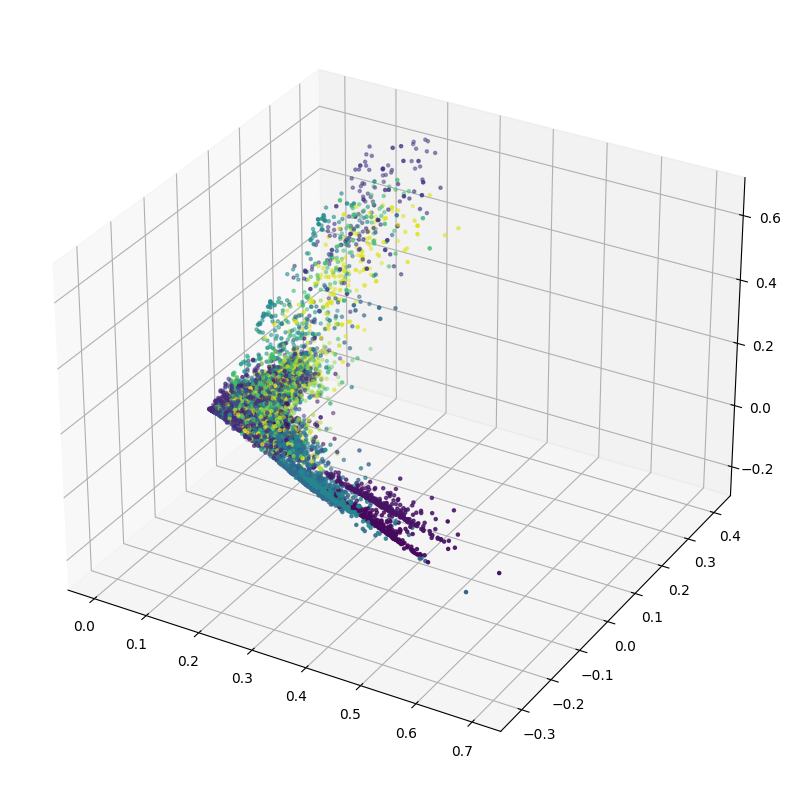

In [26]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.');

## Indexing

#### Question

In [27]:
if not pt.started():
  pt.init()

/tmp/ipykernel_31/4006547969.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipykernel_31/4006547969.py:2: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [28]:
q_indexer = pt.DFIndexer("./index_questions", overwrite=True)

q_df = pd.DataFrame({
    "docno": [str(i) for i in range(len(ds["question"]))],
    "text": ds["question"]
})

q_index_ref = q_indexer.index(q_df["text"], q_df["docno"])

q_index = pt.IndexFactory.of(q_index_ref)

/tmp/ipykernel_31/3227464377.py:1: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  q_indexer = pt.DFIndexer("./index_questions", overwrite=True)


In [29]:
query = "author odyssey"

q_tf_idf = pt.BatchRetrieve(q_index, wmodel="TF_IDF", num_results=10)
q_bm25 = pt.BatchRetrieve(q_index, wmodel="BM25", num_results=10)

/tmp/ipykernel_31/1531928263.py:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  q_tf_idf = pt.BatchRetrieve(q_index, wmodel="TF_IDF", num_results=10)
/tmp/ipykernel_31/1531928263.py:4: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  q_bm25 = pt.BatchRetrieve(q_index, wmodel="BM25", num_results=10)


In [30]:
q_tf_idf_df = q_tf_idf.search(query)
q_tf_idf_df

,qid,docid,docno,rank,score,query
0,1,26118,26118,0,12.487557,author odyssey
1,1,10851,10851,1,7.277676,author odyssey
2,1,20641,20641,2,6.598604,author odyssey
3,1,22033,22033,3,5.671743,author odyssey
4,1,398,398,4,5.165030,author odyssey
5,1,5046,5046,5,5.165030,author odyssey
6,1,21715,21715,6,5.082128,author odyssey
7,1,662,662,7,4.941931,author odyssey
8,1,4775,4775,8,4.941931,author odyssey
9,1,7582,7582,9,4.941931,author odyssey


In [31]:
q_bm25_df = q_bm25.search(query)
q_bm25_df

,qid,docid,docno,rank,score,query
0,1,26118,26118,0,22.621580,author odyssey
1,1,10851,10851,1,13.120731,author odyssey
2,1,20641,20641,2,11.896450,author odyssey
3,1,22033,22033,3,10.365567,author odyssey
4,1,398,398,4,9.439508,author odyssey
5,1,5046,5046,5,9.439508,author odyssey
6,1,21715,21715,6,9.287997,author odyssey
7,1,662,662,7,9.031776,author odyssey
8,1,4775,4775,8,9.031776,author odyssey
9,1,7582,7582,9,9.031776,author odyssey


In [32]:
q = ds['question'][q_tf_idf_df.iloc[0].docid]
print(f"Best matching question for query '{query}': \n{q}")

Best matching question for query 'author odyssey': 
Who might have been the author of the 'Odyssey' according to some theories, including one proposed by Samuel Butler?


## Word embedding (Word2Vec)

In [33]:
q_tokenized = [filter_words(s) for s in ds['question']]

d_tokenized = [filter_words(d) for s in ds['documents'] for d in s]

In [34]:
tokenized_sentences = q_tokenized + d_tokenized

In [81]:
model = Word2Vec(tokenized_sentences, vector_size=100, min_count=3, window=10, epochs=10)

In [82]:
print(f"The model has learned {len(model.wv)} word vectors")

The model has learned 152140 word vectors


In [83]:
term = "science"

print(f"Word2Vec word embedding for term='{term}': \n{model.wv[term]}")

Word2Vec word embedding for term='science': 
[-0.2937866   0.691019    0.5675206  -1.2739346   4.052976    0.80389243
  1.7967765   1.1402988   1.6244272   2.777887   -1.584315    0.08876234
 -2.5644593  -2.212906    1.8772521  -1.4950655  -0.5879633  -0.04080738
  0.50411004 -1.0012249   0.27115503 -3.2919421   2.0146627  -0.45117703
 -0.31441683 -2.5115654  -2.5128806   2.4686341   0.1746795  -0.92205447
  2.279574    1.9366059   2.2328265  -0.54223835  1.3124653   2.6020129
  1.4395411  -1.0146949  -2.3552327  -1.3277191   2.0083046   0.08761258
 -1.7871156  -2.672086   -2.2670314  -0.11662651 -0.7869414  -3.3828955
  1.3118178  -1.9836975   4.8830614   4.7199583   2.706897    4.446855
  2.1405058  -3.588909   -0.690674   -1.075744    0.8786983  -0.4005431
  3.2776341  -1.6750969  -1.6384565  -3.04904    -1.6435798  -3.0949197
 -0.0653543  -4.5231442   2.3016963   1.9151319   1.1731266  -1.9987041
 -3.0066614  -4.0439897  -1.9251388   1.7068713   0.11172617  0.42073455
  0.05639754 

In [84]:
model.wv.most_similar(term)

[('interdisciplinary', 0.6393319964408875),
 ('sciences', 0.6301419138908386),
 ('humanities', 0.6195610165596008),
 ('scientific', 0.5984372496604919),
 ('physics', 0.5845459699630737),
 ('biology', 0.5734765529632568),
 ('neuroscience', 0.5687726140022278),
 ('sociology', 0.5675163865089417),
 ('mathematics', 0.5611247420310974),
 ('anthropology', 0.5524535775184631)]

In [85]:
sample = random.sample(list(model.wv.key_to_index), 500)

word_vectors = model.wv[sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [86]:
import plotly.express as px

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

In [87]:
feelings = [
    "happiness",
    "sadness",
    "anger",
    "fear",
    "excitement",
    "disgust",
    "love",
    "anxiety",
    "hope",
    "boredom",
    "gratitude",
    "jealousy"
]

word_vectors = model.wv[feelings+sample]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [88]:
r = (-200,200)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=feelings + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

In [89]:
vec = model.wv.get_vector('king') + (model.wv.get_vector('woman') - model.wv.get_vector('man'))

In [90]:
model.wv.similar_by_vector(vec)

[('king', 0.8487798571586609),
 ('queen', 0.7106554508209229),
 ('throne', 0.6849580407142639),
 ('empress', 0.6472697854042053),
 ('prince', 0.6467353105545044),
 ('monarch', 0.6335229277610779),
 ('kingship', 0.6200154423713684),
 ('consort', 0.6145816445350647),
 ('emperor', 0.6139277219772339),
 ('princess', 0.6108972430229187)]